## Profiled attack example

In [54]:
#import python libraries

from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.models import load_model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

from tqdm import tnrange,tqdm_notebook

### Read Data 

In [15]:
simulated_traces = pd.read_csv('../real_traces/random_2500/random_1300.csv')
simulated_metadata= simulated_traces['label']
simulated_traces.drop('label',axis=1)

simulated_traces = np.array(simulated_traces)
simulated_metadata = np.array(simulated_metadata)

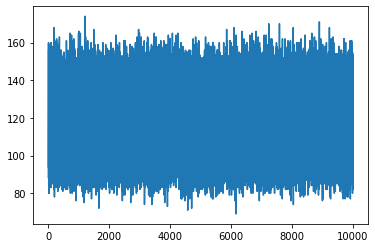

In [20]:
plt.plot(simulated_traces.T[0])

In [21]:
simulated_metadata

array([118, 207,  61, ...,  30, 212, 242])

In [25]:
simulated_metadata

array([118, 207,  61, ...,  30, 212, 242])

## Correltion Example

In [24]:
len(simulated_metadata.T)

10000

In [26]:
len(simulated_traces.T[24])

10000

In [14]:
mergedData = np.column_stack((simulated_traces.T[24], simulated_metadata.T[1]))
df_merged_mergedData = pd.DataFrame(mergedData)

In [15]:
len(mergedData)

100000

In [27]:
# Draw correlation with SAS
def drawCorr(df):
    sns.set(style="white")
    sns.set_palette("coolwarm",9)
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(10, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', vmax=1, center=0, vmin=-1,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    sns.set_style("whitegrid")

In [30]:
from numpy import *

tmpCorr = []
for i in range(0,1300):
    mergedData = np.column_stack((simulated_traces.T[i], simulated_metadata))   
    df_merged_mergedData = pd.DataFrame(mergedData)
    #print(i,df_merged_mergedData.corr().unstack().sort_values().drop_duplicates()[0:1].values)
    tmpCorr.append(df_merged_mergedData.corr().unstack().sort_values().drop_duplicates()[0:1].values[0]) 
    
corr_index = np.argmax(tmpCorr)
print(corr_index) 

69


## Attack 1 - Correlation

In [31]:
# AES Sbox
AES_Sbox = np.array([
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
            ])

In [32]:
# Compute the HW for the key and plaintext
def computeHW(plaintext,key):
    listHW = []
    for p in plaintext:
        tmpHW = AES_Sbox[p^key] 
        listHW.append(tmpHW)
    return np.array(listHW)

In [33]:
# Get the key by the maximum correlation
def getKey(keyList):
    tmpCorr = []
    for i in keyList:
        tmpCorr.append(i[1])
    keyIndex = np.argmax(tmpCorr)
    return(keyList[keyIndex])

In [82]:
import time

def startCorrelationAttack(traces,metadata):
    #tmpCorr = []
    tmpList=[]
    fullList = []
    print('--- Start Correlation Attack ---')
    for i in tnrange(0,1300):
        tmpCorr = []
        keylist = []
        #print('Sample:',i)
        for k in range(0,255):
            # Compute the HW of the current key
            tmpHW = computeHW(metadata,k)
            #print(tmpHW)
            # Create new arrawy with the races 
            mergedData = np.column_stack((traces[i], tmpHW))
            # Tranform array to DataFrame
            df_mergedData = pd.DataFrame(mergedData)
            # Get correlation 
            tmpCorr.append(df_mergedData.corr().unstack().sort_values().drop_duplicates()[0:1].values[0])
            # Add current key to list
            keylist.append(k)
        # Get maximum correlation per sample
        fullList.append((np.argmax(tmpCorr),tmpCorr))
        tmpList.append((keylist[np.argmax(tmpCorr)],np.max(tmpCorr),i))
    # Get the final key
    print('--- Finished Correlation Attack ---',i,time.time())
    finalKey = getKey(tmpList)
    print('Key:',finalKey[0],'\nSample:',finalKey[2],'\nCorrelation:',finalKey[1]) 
    
    finalData = [fullList,tmpList]
    return finalData
    #%matplotlib inline
    #import mpld3
    #mpld3.enable_notebook()

In [ ]:
corrAttackData = startCorrelationAttack(simulated_traces.T[0:10000],simulated_metadata[0:10000])

In [86]:
def plotAllCorr(myData):
    maxCorr=[]
    for i in myData:
        maxCorr.append(i[1])
    plt.plot(maxCorr)
    plt.show()
    #return test

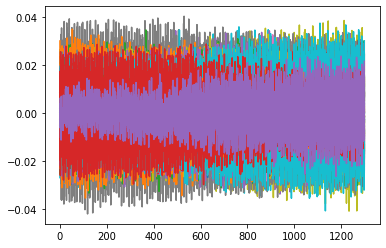

In [87]:
plotAllCorr(corrAttackData[0])